In [18]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MaxAbsScaler,  MinMaxScaler
from sklearn.model_selection import LeaveOneOut

from library.utils import *
from library.model import *
from library.active_learning import *

<Figure size 640x480 with 0 Axes>

## Inputs

- **name_plate**: Name of the last plate for which experiments were performed (eg. 'plate 0', 'plate 1', ..., 'plate 10)
- **name_list**: List of column names for replicate MG yield measurements (e.g., 'MG_yield_1' to 'MG_yield_6'). These values serve as input data for training the active learning model.
- **parameter_file**: A CSV file defining the combinatorial space for model exploration. Each row represents a component, with the first column being the component name, the second column the maximum concentration, and the remaining columns representing concentration ratios (weights). These ratios multiply the maximum concentration to create a range of concentrations to be tested for each component.

- **nb_rep**: Number of random train/test splits used to evaluate model performance. Higher values improve reliability but increase runtime.
- **flatten**: If True, all replicate measurements are used for training; if False, their mean is used.
- **seed**: Random seed for reproducibility of generated experiments. Change this value each round.
- **nb_new_data_predict** : Number of new, unique experiments the model should generate by randomly sampling the design space. Redundant (already tested) combinations will be removed, and the best candidates will be selected based on the active learning model.
- **nb_new_data** : Number of experiments to test in the next round.

- **save_name**: path and file names for result files (eg: "round11")

In [5]:
name_plate = 'plate 10'
name_list = ['MG_yield_1','MG_yield_2','MG_yield_3','MG_yield_4','MG_yield_5','MG_yield_6']

plate_number = int(name_plate.split(' ')[-1])
# Assign the correct parameter file based on the plate number
if 0 <= plate_number <= 4:
    parameter_file = 'INPUT//params.csv'
elif 5 <= plate_number <= 6:
    parameter_file = 'INPUT//params_new.csv'
elif plate_number == 7:
    parameter_file = 'INPUT//params_new_plate7.csv'
elif plate_number == 8:
    parameter_file = 'INPUT//params_new_plate8.csv'
elif plate_number in [9, 10]:
    parameter_file = 'INPUT//params_new_plate10.csv'

nb_rep = 10
flatten = False
seed = 83
nb_new_data_predict = 100000
nb_new_data = km = 50

save_name = 'round11'

**Step 1 - Read the parameter file:**
- Validates component names.
- Poolsize is the total number of possible combinations based on the parameter grid.
- Searching ratio is the percentage of the parameter space explored by the newly generated data in active learning.

In [6]:
element_list, element_max, sampling_condition = import_parameter(parameter_file, nb_new_data_predict, verbose = True)
print("element_list =", element_list)
print("element_max =", element_max)
print("sampling_condition =", sampling_condition)

Number of metabolites : 8
Number of combinations - poolsize : 1679616
Searching ratio : 5.95 %
Possible concentrations: 


,Mg-glutamate,K-glutamate,Amino acid,Spermidine,3-PGA,NTPs,PEG-8000,DNA
0,18.0,0.0,0.0,0.000,4.5,9.0,0.00,7.5
1,19.4,0.0,0.0,0.495,12.0,10.8,0.99,8.0
2,20.8,0.0,0.0,0.750,16.5,12.6,1.50,8.5
3,22.2,0.0,0.0,1.005,21.0,14.4,2.01,9.0
4,23.6,0.0,0.0,1.245,25.5,16.2,2.49,9.5
5,25.0,0.0,0.0,1.500,30.0,18.0,3.00,10.0


element_list = ['Mg-glutamate', 'K-glutamate', 'Amino acid', 'Spermidine', '3-PGA', 'NTPs', 'PEG-8000', 'DNA']
element_max = [25.0, 80.0, 1.8, 1.5, 30.0, 18.0, 3.0, 10.0]
sampling_condition = [[18.    19.4   20.8   22.2   23.6   25.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.495  0.75   1.005  1.245  1.5  ]
 [ 4.5   12.    16.5   21.    25.5   30.   ]
 [ 9.    10.8   12.6   14.4   16.2   18.   ]
 [ 0.     0.99   1.5    2.01   2.49   3.   ]
 [ 7.5    8.     8.5    9.     9.5   10.   ]]


**Step 2 - Read the CSV file containing compiled data from previous rounds**

In [7]:
# Load the csv file containing compiles data from previous rounds
try:
    plate_num = int(name_plate.split("plate ")[1])
except (IndexError, ValueError):
    raise ValueError("Invalid 'name_plate' format. Expected format: 'plate X'.")
if plate_num > 10:
    raise ValueError("Plate number exceeds 10. No corresponding file defined.")
prefix = '_'.join([f'P{i}' for i in range(plate_num + 1)])
filename = f"{prefix}_AL_corr_everything_MG_GFP.csv"
data = pd.read_csv(f"..//1-From biotek data to active learning//OUTPUT//{filename}")
# Count the number of ingredient of the buffer
no_element = len(element_list)
# Extract the composition of the buffer that have been tested in previous rounds
X = data.iloc[:,0:no_element]
# Extract the MG yield measurements (e.g., 'MG_yield_1' to 'MG_yield_6', input data for training the model)
y = np.array(data[name_list])
# Remove control buffers (repetition in the plate n+i of a buffer created in plate n)
duplicated_mask = X.duplicated()
X = X[~duplicated_mask].reset_index(drop=True)
y = y[~duplicated_mask.values]

## Modeling

- Step 1: Normalize X by dividing each column by its maximum value.
- Step 2: Use grid search with 5-fold cross-validation to select the best Gaussian Process kernel, trained on all data.
- Step 3: Evaluate the best model’s performance on separate test subsets.

**Step 1 - Normalize X by dividing each column by its maximum value**

In [11]:
# Splits the data X (features) and y (target labels) into training and test sets
X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0, flatten = flatten) # ratio=0 : entire dataset
# Scaling data : each feature in X_train is divided by the maximum absolute value of that feature, ensuring the values are between -1 and 1
scaler = MaxAbsScaler()
# Fits the scaler to X_train and transforms the data into the normalized range
X_train_norm = scaler.fit_transform(X_train)

**Step 2 - Use grid search with 5-fold cross-validation to select the best Gaussian Process kernel, trained on all data**

*Step 2.1 - Defining the hyperparameter search space*
- **params**: dictionary specifying the hyperparameter search space, including **'kernel'** (a list of Gaussian Process kernel functions to test) and **'alpha'** (a list of values controlling the noise level assumed in the training targets)

Here, **'kernel'** contains several Gaussian Process kernel functions to test, structured as following: 
- A constant term (C())
- A Matern kernel (nu=smoothness)
- A WhiteKernel to model noise.

Other kernel options (like RBF or combinations of Matern and RBF) could be tested.

In [16]:
params = {'kernel': [
                C()*Matern(length_scale=10, nu=2.5)+ WhiteKernel(),
                C()*Matern(length_scale=10, nu=1.5)+ WhiteKernel(),
                C()*Matern()+ WhiteKernel()
            ],
            'alpha':[0.1, 0.3, 0.5, 0.8]}

*Step 2.2 - Running the model*

In [17]:
# Initialize the model
model = BayersianModels(n_folds= 10, model_type = 'gp', params=params)
# Train the model
model.train(X_train_norm, y_train)
# Predict
y_pred_train, std_pred_train = model.predict(X_train_norm) 

Best hyperparameter found: {'alpha': 0.8, 'kernel': 1**2 * Matern(length_scale=10, nu=2.5) + WhiteKernel(noise_level=1)}


**Step 3 - Evaluate the best model’s performance on separate test subsets**

In [ ]:
best_param = {'kernel': [model.best_params['kernel']]}

res = []
nb_rep = 10
for i in range(nb_rep):
    # Data splitting and normalization (80% train, 20% test)
    X_train, X_test, y_train, y_test = split_and_flatten(X, y, ratio = 0.2, flatten = flatten)
    scaler = MaxAbsScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    # Model evaluation
    eva_model = BayersianModels(model_type ='gp', params= best_param)
    eva_model.train(X_train_norm, y_train, verbose = False)
    y_pred, std_pred = eva_model.predict(X_test_norm)
    # Computing performance metric
    res.append(r2_score(y_test, y_pred))

plt.hist(res, bins = 20, color='orange')
plt.title(f'Histogram of R2 for 10 different testing subset for {name_plate}, mean = {np.mean(res):.2f}', size = 12)

## Active Learning

General strategy:
- Step 1: Randomly generate "nb_new_data_predict" new experiments based on the condition lists.

- Step 2: Use the trained model to predict the yields of these new experiments.

- Step 3: Apply three acquisition functions (UCB, PI, and EI) to evaluate the usefulness of each experiment, aiming to either improve model performance or yield.

- Step 4: Select the top "nb_new_data" experiments that are expected to provide the most benefit for lab testing.

- Step 5: Vizualise active learning output and compare the three acquisition functions: ucb, ei, pi

- Step 6: Saving results : experiments to perform in next plate

**Step 1: Randomly generate a lot of new buffer compositions (=experiments)**

Generate a list of buffer conditions and predict their MG_yield to select the most promising buffer conditions to test in the lab

In [ ]:
# Should not be changed (allow for clusters, not used in this simple version of the code)
n_group = 10
# Randomly generate new buffer compositions
X_new= sampling_without_repeat(sampling_condition, nb_sample = nb_new_data_predict, exited_data=X_train, seed = seed)


For UCB:
Maximum yield prediction = 17.72319092307984
For PI:
Maximum yield prediction = 18.024463902445447
For EI:
Maximum yield prediction = 18.024463902445447


**Step2: Use the trained model to predict the yields of these new experiments**

*Step 2.1 - Predict*

In [ ]:
# Normalize new buffer compositions
X_new_norm = scaler.transform(X_new)
# Use model to predict the MG_yield of the new buffer compositions 
y_pred, std_pred = model.predict(X_new_norm)
clusters = cluster(X_new_norm, n_group)

*Step 2.2 - Plot Histogram of yield and standard deviation for prediction and training data**

Compare the yield and standard deviation between all new experiments and previous ones.
This will help identify potential points for increasing yield and also determine the optimal theta value to balance exploration and exploitation when using UCB.

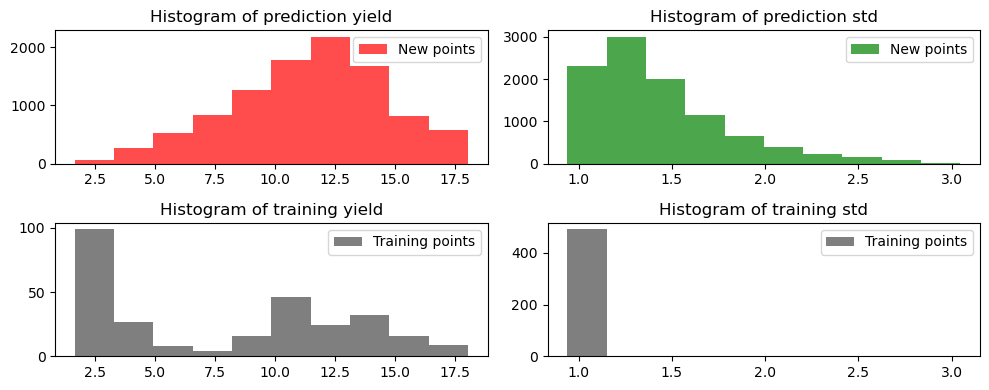

In [20]:
plot_hist_yield_std(y_pred, y_train, std_pred, std_pred_train)

**Step3: Apply three acquisition functions (UCB, PI, and EI) to evaluate the usefulness of each experiment, aiming to either improve model performance or yield**


In [29]:
# Calculate acquisition functions: UCB (Upper Confidence Bound), PI (Probability of Improvement) and EI (Expected Improvement)
theta = 4
ucb = y_pred + theta*std_pred
pi = probability_of_improvement(y_pred, std_pred, max(y_train))
ei = expected_improvement(y_pred, std_pred, max(y_train))

**Step4: Select the top "nb_new_data" experiments that are expected to provide the most benefit for lab testing**


In [ ]:
# Select Top Experiments Based on Each Acquisition Function
print("For UCB:")
ucb_top, y_ucb, ratio_ucb, ucb_cluster = find_top_element(X_new, y_pred, clusters, ucb, km, return_ratio= True)
print("For PI:")
pi_top, y_pi, ratio_pi, pi_cluster = find_top_element(X_new, y_pred, clusters, pi, km, return_ratio= True)
print("For EI:")
ei_top, y_ei, ratio_ei, ei_cluster = find_top_element(X_new, y_pred, clusters, ei, km, return_ratio= True)

**Step 5 - Vizualise active learning output and compare the three acquisition functions: ucb, ei, pi**

*Step 5.1 - Plot scatter plot comparing yield and std for each acquisition function*

Compare the yield and standard deviation of selected points against non-selected points, helping to visualize the effectiveness of the selected experiments.

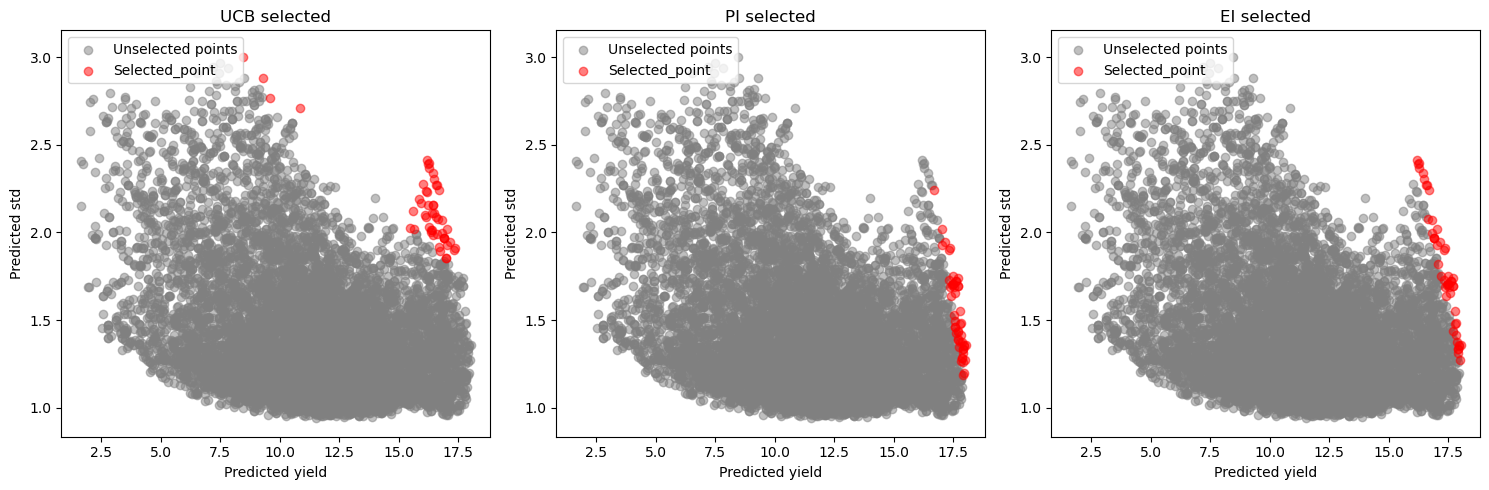

In [ ]:
# Set up the figure with three subplots in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

plot_selected_point(axes[0], y_pred, std_pred, y_ucb, 'UCB selected')
plot_selected_point(axes[1], y_pred, std_pred, y_pi, 'PI selected')
plot_selected_point(axes[2], y_pred, std_pred, y_ei, 'EI selected')
# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

*Step 5.2 - Plot Euclidean distance from each point to the first (ie most interesting) point*

Calculate and plot the Euclidean distance from each new point to the first/most beneficial point. 
This will ensure that the newly selected points are not too close to each other (i.e., not clustered) and that their acquisition values differ significantly from those of the non-selected points, ensuring they are promising.

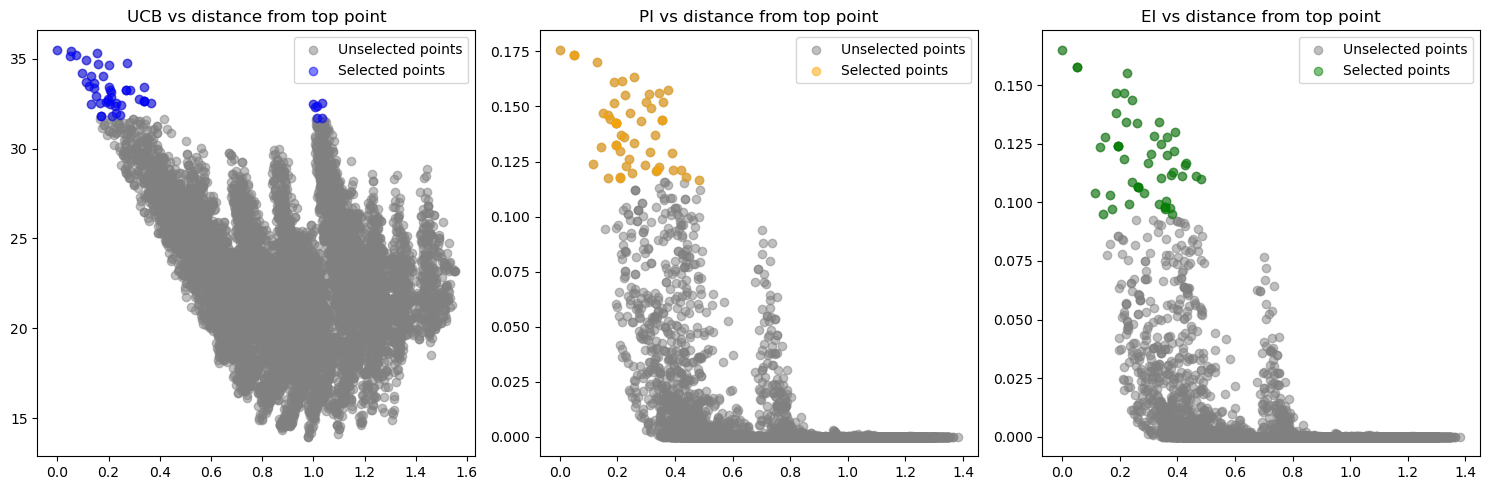

In [22]:
ucb_top_norm = scaler.transform(ucb_top)
pi_top_norm = scaler.transform(pi_top)
ei_top_norm = scaler.transform(ei_top)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_distance(axes[0], X_new_norm,ucb_top_norm, ucb, ratio_ucb, 'blue', 'UCB vs distance from top point')
plot_distance(axes[1], X_new_norm,pi_top_norm, pi, ratio_pi, 'orange', 'PI vs distance from top point')
plot_distance(axes[2], X_new_norm,ei_top_norm, ei, ratio_ei, 'green', 'EI vs distance from top point')

plt.tight_layout()
plt.show()

*Step 5.3 - Boxplot of yield evolution across plates with model prediction for next plate*

Display the distribution of experimental MG yields for each tested plate using a boxplot, and add the predicted MG yields for the next planned plate as grey dots or a separate grey box to visually compare expected outcomes with previous experimental results.
This plot allows for tracking performance over time, evaluating whether the model is effectively guiding improvements, and setting expectations for the upcoming experimental round.

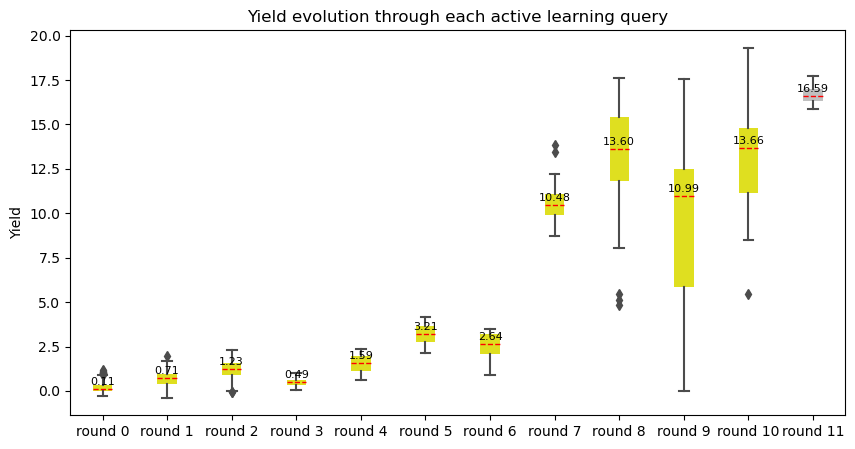

In [ ]:
acq = {'ucb': y_ucb, 'pi': y_pi, 'ei': y_ei}
size_list = data.groupby("name_plate").size().tolist() # list of the number of experiments per plate
y = np.array(data[name_list])
y_mean = np.nanmean(y, axis = 1)
y_std = np.nanstd(y, axis = 1)

size_list.append(nb_new_data)
y_mean = np.append(y_mean, acq['ucb'])
plot_each_round(y_mean,size_list, predict = True)

*Step 5.4 - Generate histograms of cocnentration of each element of the buffer (compound) tested in previous and new data*

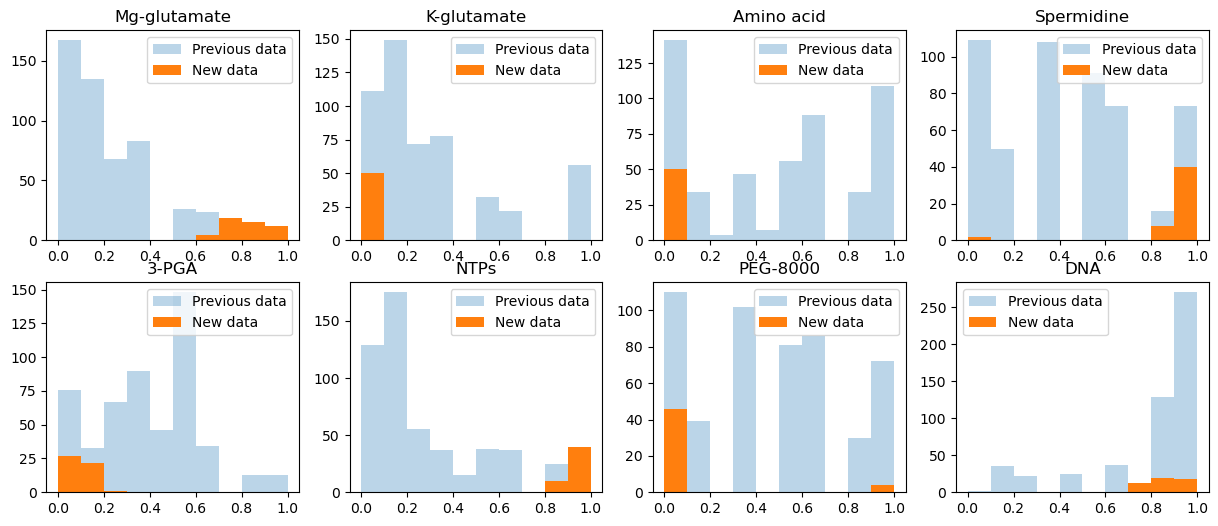

In [24]:
acq = {'ucb': ucb_top_norm, 'pi': pi_top_norm, 'ei': ei_top_norm}
plot_train_test(X_train_norm, acq['ucb'], element_list)

*Step 5.5 - Plot heatmap of all generated experiments with its yield from low to high, color represent substance concentrations, use to look for each factor-X influence on yield-y*

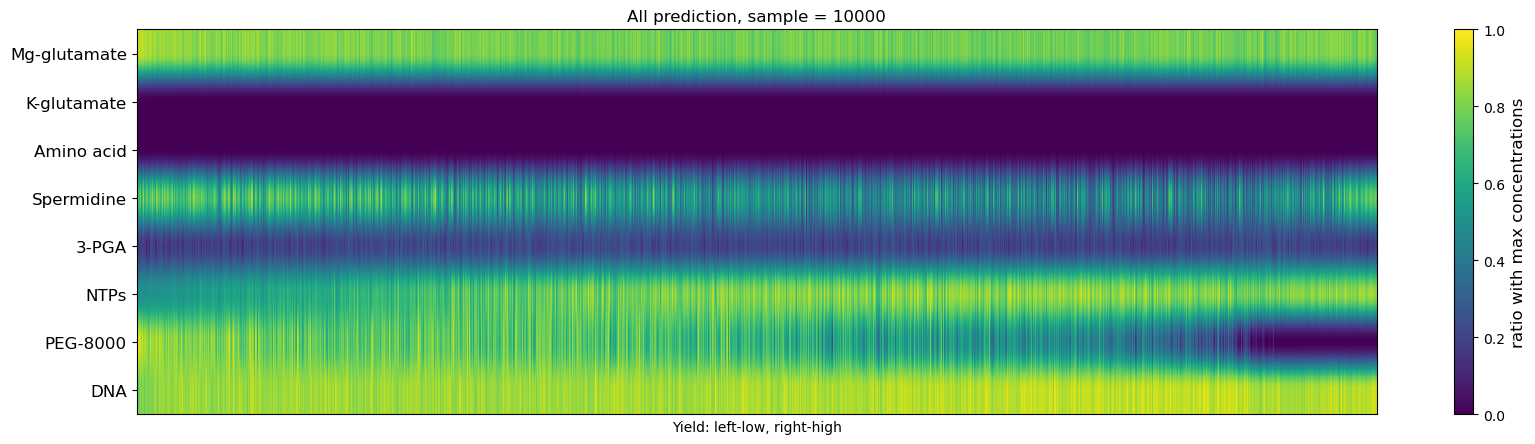

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
plot_heatmap(axes, X_new_norm, y_pred, element_list, 'All prediction')
plt.xlabel("Yield: left-low, right-high")
plt.show()

*Step 5.6 - Similar plot but zoom on top selected points*

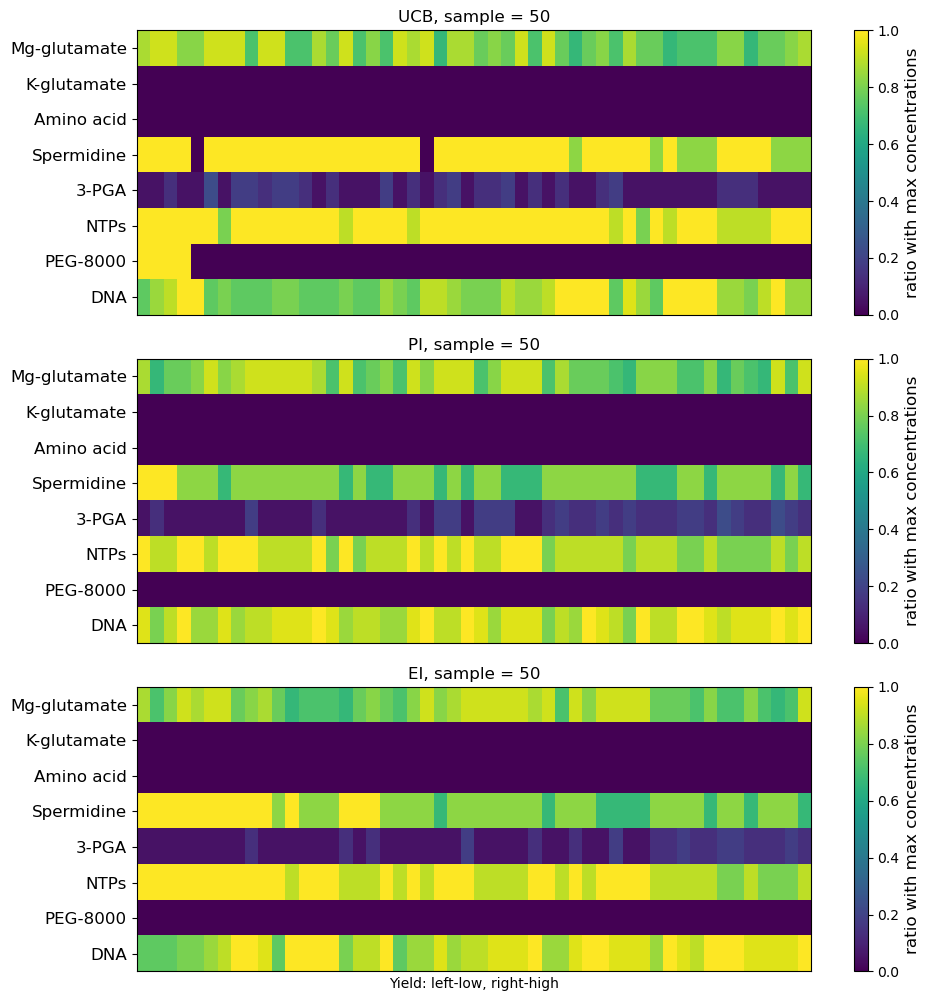

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
plot_heatmap(axes[0], ucb_top_norm, y_ucb, element_list, 'UCB')
plot_heatmap(axes[1], pi_top_norm, y_pi, element_list, 'PI')
plot_heatmap(axes[2], ei_top_norm, y_ei, element_list, 'EI')
plt.tight_layout()
plt.xlabel("Yield: left-low, right-high")
plt.show()

**Step 6 - Saving results : experiments to perform in next plate**

In [ ]:
# Save top-ranked conditions (pi_top, ei_top, ucb_top) as separate CSVs
X_pi = pd.DataFrame(pi_top, columns=element_list)
name = save_name + '_pi.csv'
X_pi.to_csv(name, index=False)

X_ei = pd.DataFrame(ei_top, columns=element_list)
name = save_name + '_ei.csv'
X_ei.to_csv(name, index=False)

X_ucb = pd.DataFrame(ucb_top, columns=element_list)
name = save_name + '_ucb.csv'
X_ucb.to_csv(name, index=False)

In [ ]:
# Create full DataFrame with predicted yield + acquisition scores
data_new = pd.DataFrame(X_new, columns=element_list)
data_new.loc[:,'predict_yield'] = y_pred
data_new.loc[:,'pi'] = pi
data_new.loc[:,'ei'] = ei
data_new.loc[:,'ucb'] = ucb

# Keep only top UCB-selected points with annotations
data_new = pd.merge(X_ucb, data_new, on=element_list, how='left')
name = save_name + '_combine.csv'
data_new.to_csv(name, index=False)